In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
BBOX_CSV = '../tmp/rsna_bbox.csv'
TRN = 'train'
TEST = 'test2'

In [34]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)

In [35]:
md = ImageClassifierData.from_csv(rsna_path, TRN, BBOX_CSV, tfms=tfms, bs=64, test_name=TEST, continuous=True, suffix='.dcm')

In [36]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [81]:
learn.save('../tmp/rsna_tmp_01.pth')

In [7]:
learn.load('../tmp/rsna_tmp_01.pth')

In [37]:
learn.lr_find(1e-7, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 330/363 [03:34<00:21,  1.54it/s, loss=391] 

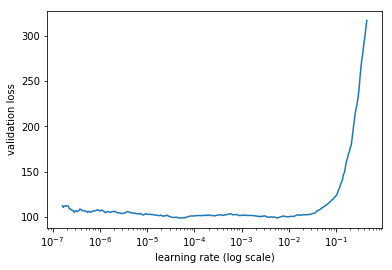

In [38]:
learn.sched.plot()

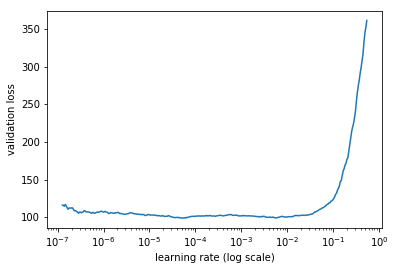

In [39]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [40]:
lr = 1.5e-2

In [41]:
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  0%|          | 0/363 [00:00<?, ?it/s]                    


Exception in thread Thread-29:
Traceback (most recent call last):
  File "/home/edwin/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/edwin/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/edwin/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      97.365816  93.224904 
    1      99.619159  96.763492                             
    2      92.792124  100.691136                            



[100.69113556771561]

In [42]:
x, y = next(iter(md.trn_dl))

In [30]:
y[:10]

tensor([[ 154.,  456.,  207.,  195.],
        [   0.,    0.,    0.,    0.],
        [ 244.,  477.,  180.,   95.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 240.,  667.,  208.,   92.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 243.,  412.,  191.,  252.]], device='cuda:0')

In [31]:
trn_preds = to_np(predict_batch(learn.model, x))[:10]


In [43]:
trn_preds

array([[ 0.05134, -0.74639,  0.1493 , -0.37264],
       [-0.35741,  0.12476,  0.22953,  0.20753],
       [ 0.38265, -0.16544,  0.33179,  0.52827],
       [ 0.26704,  0.09578,  0.69564,  0.50498],
       [ 0.06311,  0.22747,  0.27012,  0.20015],
       [ 0.35938,  0.00857,  0.28793,  0.40019],
       [ 0.03378, -0.15611,  0.74983, -0.01033],
       [ 0.02776, -1.0334 ,  0.30497, -0.38968],
       [-0.00779,  0.08086,  0.31677,  0.13288],
       [ 0.50517,  0.11477, -0.03096,  0.30765]], dtype=float32)

In [47]:
preds = learn.predict(is_test=True)

In [48]:
len(preds)

1000

In [50]:
x, y = next(iter(md.test_ds))

In [51]:
y

array([ 0.,  0.,  0.,  0.])

In [52]:
preds[0]

array([ 235.05376,  238.94989,  251.2547 ,  262.35345], dtype=float32)

In [54]:
learn.freeze_to(-2)

In [56]:
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      103.965298 109.699609
    1      79.887241  81.350479                             
    2      79.590882  75.645837                             



[75.645836820762]

In [58]:
learn.unfreeze()

In [9]:
lr= 2e-2

In [59]:
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      93.981761  110.957227
    1      91.020227  87.643007                             
    2      90.179559  91.630195                             



[91.630194564800917]

In [10]:
lrs = np.array([lr/100,lr/10,lr])

In [11]:
learn.fit(lrs, 2, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      90.05667   88.865662 
    1      91.06494   88.56379                              
    2      90.655446  88.470089                             
    3      90.819515  88.309626                             
    4      87.967427  87.938751                             
    5      90.457638  87.927624                             



[87.927624259752633]

In [61]:
trn_preds = learn.predict()

In [12]:
x, y = next(iter(md.trn_dl))

In [13]:
trn_preds = predict_batch(learn.model, x)

In [14]:
trn_preds = to_np(trn_preds)

In [18]:
y[:10]

tensor([[ 309.,  286.,  131.,  158.],
        [ 281.,  390.,  160.,  264.],
        [   0.,    0.,    0.,    0.],
        [ 205.,  293.,  226.,  401.],
        [ 143.,  334.,  270.,  589.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.],
        [ 309.,  297.,  208.,  293.]], device='cuda:0')

In [19]:
trn_preds[:10]

array([[ 278.84158,  262.75092,  216.69446,  316.96228],
       [   3.33172,    5.51596,    5.21257,    5.40469],
       [  -0.43675,   -0.24368,   -0.048  ,   -0.06667],
       [ 245.5896 ,  237.6369 ,  188.09424,  283.66803],
       [  10.24407,   10.8076 ,    9.45464,   11.51579],
       [   0.11729,    0.02869,    0.10004,    0.1884 ],
       [  -1.04462,   -0.56674,   -0.82559,   -1.67053],
       [  -0.     ,    0.     ,    0.     ,    0.     ],
       [ 267.62518,  253.25366,  230.12265,  332.98596],
       [  80.14738,   93.98895,   94.69958,  100.41895]], dtype=float32)

In [20]:
test_preds = learn.predict(is_test=True)

In [27]:
def get_key(fname):
    return fname.split('/')[1].split('.dcm')[0]

In [23]:
def get_pred(pred):
    x, y, width, height = pred.tolist()
    return f"1.0 {x} {y} {width} {height}"

In [28]:
fnames = list(map(get_key, md.test_ds.fnames))
pred_strings = list(map(get_pred, test_preds))
test_pairs = list(zip(fnames, pred_strings))

In [29]:
TEST_CSV = '../tmp/rsna_test_predictions.csv'
df_test = pd.DataFrame(test_pairs, columns=["patientId", "PredictionString"])
df_test.to_csv(TEST_CSV, index=False)
FileLink(TEST_CSV)

/home/edwin/Developer/kaggle-comps/tmp/rsna_test_predictions.csv

In [30]:
TEST_CSV

'../tmp/rsna_test_predictions.csv'

In [44]:
TEST_CSV

NameError: name 'TEST_CSV' is not defined